In [20]:
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [21]:
parser = Sbopen()

In [22]:
match = parser.match(competition_id=9, season_id=281)

In [23]:
match.loc[match['match_week']==21]

,match_id,match_date,kick_off,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,...,competition_stage_id,competition_stage_name,stadium_id,stadium_name,stadium_country_id,stadium_country_name,referee_id,referee_name,referee_country_id,referee_country_name
21,3895232,2024-02-10,2024-02-10 19:30:00,3,0,available,available,2024-05-07 19:31:47.936488,2024-05-07 19:36:17.578845,21,...,1,Regular Season,377,BayArena,85,Germany,241,Felix Zwayer,85,Germany


In [24]:
event, related, freeze, tactics = parser.event(3895232)

## Preparing the data

In [25]:
event.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'duration', 'match_id', 'type_id', 'type_name', 'possession_team_id',
       'possession_team_name', 'play_pattern_id', 'play_pattern_name',
       'team_id', 'team_name', 'tactics_formation', 'player_id', 'player_name',
       'position_id', 'position_name', 'pass_recipient_id',
       'pass_recipient_name', 'pass_length', 'pass_angle', 'pass_height_id',
       'pass_height_name', 'end_x', 'end_y', 'sub_type_id', 'sub_type_name',
       'body_part_id', 'body_part_name', 'x', 'y', 'under_pressure',
       'outcome_id', 'outcome_name', 'aerial_won', 'counterpress',
       'pass_switch', 'out', 'off_camera', 'foul_committed_advantage',
       'foul_won_advantage', 'pass_assisted_shot_id', 'pass_shot_assist',
       'shot_statsbomb_xg', 'end_z', 'shot_key_pass_id', 'technique_id',
       'technique_name', 'goalkeeper_position_id', 'goalkeeper_position_name',
       'shot_first_time', 'pass_cross', 'pass_

In [26]:
event.player_name.unique()

array([nan, 'Leroy Sané', 'Manuel Neuer', 'Amine Adli',
       'Alejandro Grimaldo García', 'Noussair Mazraoui', 'Florian Wirtz',
       'Dayotchanculle Upamecano', 'Min Jae Kim', 'Nathan Tella',
       'Edmond Fayçal Tapsoba', 'Jamal Musiala', 'Josip Stanišić',
       'Piero Martín Hincapié Reyna', 'Robert Andrich',
       'Aleksandar Pavlović', 'Harry Kane', 'Jonathan Tah', 'Eric Dier',
       'Sacha Boey', 'Lukáš Hrádecký', 'Granit Xhaka', 'Leon Goretzka',
       'Joshua Kimmich', 'Thomas Müller', 'Jeremie Frimpong',
       'Mathys Tel', 'Jonas Hofmann', 'Raphaël Adelino José Guerreiro',
       'Jean-Eric Maxim Choupo-Moting', 'Adam Hložek',
       'Gustavo Adolfo Puerta Molano'], dtype=object)

In [27]:
lev_pass = event.loc[(event['team_name']=='Bayer Leverkusen') & (event['type_name']=='Pass') & (event['type_name'] != 'Throw-in')][['x','y','end_x','end_y']]

In [60]:
lev_pass

,x,y,end_x,end_y
9,36.6,15.7,50.1,7.0
34,56.7,59.6,49.2,70.5
37,49.2,70.5,38.0,28.0
40,39.7,29.5,44.6,37.1
43,47.7,33.5,49.0,12.6
...,...,...,...,...
4070,10.9,31.4,57.7,14.2
4079,62.7,4.5,119.6,9.5
4099,7.0,40.0,66.9,11.5
4121,32.2,0.1,53.7,12.0


### plot all passes

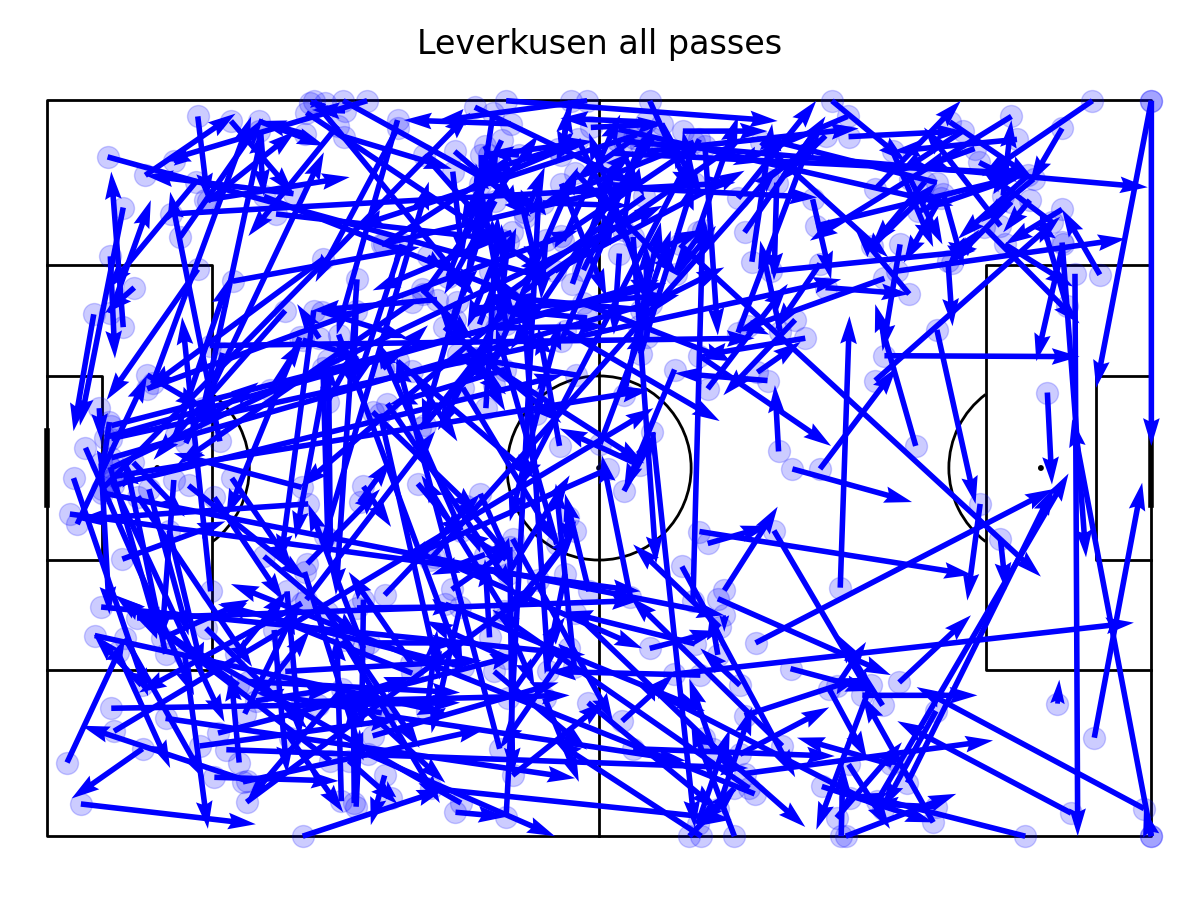

In [61]:
pitch = Pitch('statsbomb', line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

pitch.arrows(lev_pass.x,lev_pass.y,lev_pass.end_x,lev_pass.end_y,color='blue',ax=ax['pitch'])
pitch.scatter(lev_pass.x,lev_pass.y,alpha=0.2,s=250,color='blue',ax=ax['pitch'])
fig.suptitle("Leverkusen all passes", fontsize = 24)
plt.show()

In [62]:
# add angles
lev_pass['angle'] = np.arctan2(lev_pass["end_y"] - lev_pass["y"], lev_pass["end_x"] - lev_pass["x"])

In [63]:
lev_pass

,x,y,end_x,end_y,angle
9,36.6,15.7,50.1,7.0,-0.572460
34,56.7,59.6,49.2,70.5,2.173473
37,49.2,70.5,38.0,28.0,-1.828467
40,39.7,29.5,44.6,37.1,0.998130
43,47.7,33.5,49.0,12.6,-1.508675
...,...,...,...,...,...
4070,10.9,31.4,57.7,14.2,-0.352198
4079,62.7,4.5,119.6,9.5,0.087648
4099,7.0,40.0,66.9,11.5,-0.444095
4121,32.2,0.1,53.7,12.0,0.505517


### Clustering the passes

In [64]:
from sklearn.cluster import KMeans

def k_means_clustering(data, num_clusters):

    # 使用 k-means 算法进行聚类
    kmeans = KMeans(n_clusters=num_clusters, random_state=1)
    labels = kmeans.fit_predict(data)
    
    return labels

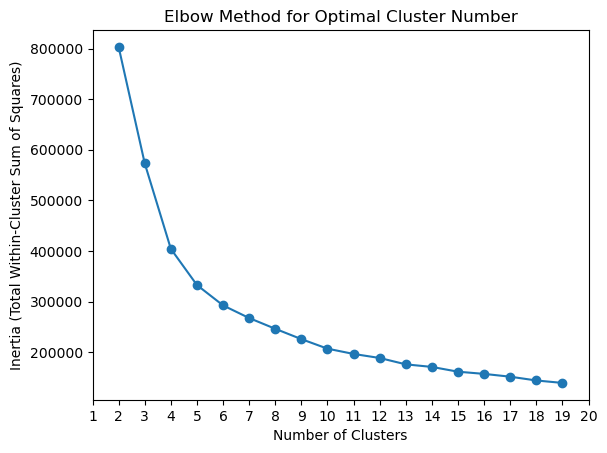

In [65]:
# 设定聚类数量

# 尝试不同的聚类簇数
cluster_range = range(2, 20, 1)
inertia_values = []

for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=1)
    kmeans.fit(lev_pass)
    inertia_values.append(kmeans.inertia_)

# 绘制肘部法图像
plt.plot(cluster_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal Cluster Number')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Total Within-Cluster Sum of Squares)')
plt.xticks(np.linspace(1, 20, 20))
plt.show()

In [66]:
# n=10

# 设定聚类数量
num_clusters = 10
# 进行聚类
cluster_labels = k_means_clustering(lev_pass, num_clusters)

# 将聚类标签添加到原始数据
lev_pass['cluster'] = cluster_labels

# 展示每个类别的平均值
cluster_means = lev_pass.groupby('cluster').mean()

# 打印结果
print("每个类别的平均值：")
cluster_means

每个类别的平均值：


,x,y,end_x,end_y,angle
cluster,,,,,
0,28.007692,65.490385,38.759615,65.576923,-0.255731
1,71.653061,19.534694,77.259184,17.185714,0.016868
2,63.752381,63.447619,65.295238,63.719048,-0.488426
3,98.626000,12.572000,101.626000,16.838000,0.623799
4,13.248485,50.624242,13.684848,55.166667,0.295863
5,44.516071,39.812500,45.558929,39.028571,-0.009173
6,10.062500,37.243750,66.931250,23.325000,-0.242083
7,51.061429,11.588571,53.907143,13.311429,0.250838
8,91.815385,66.261538,97.007692,63.543590,-0.369320


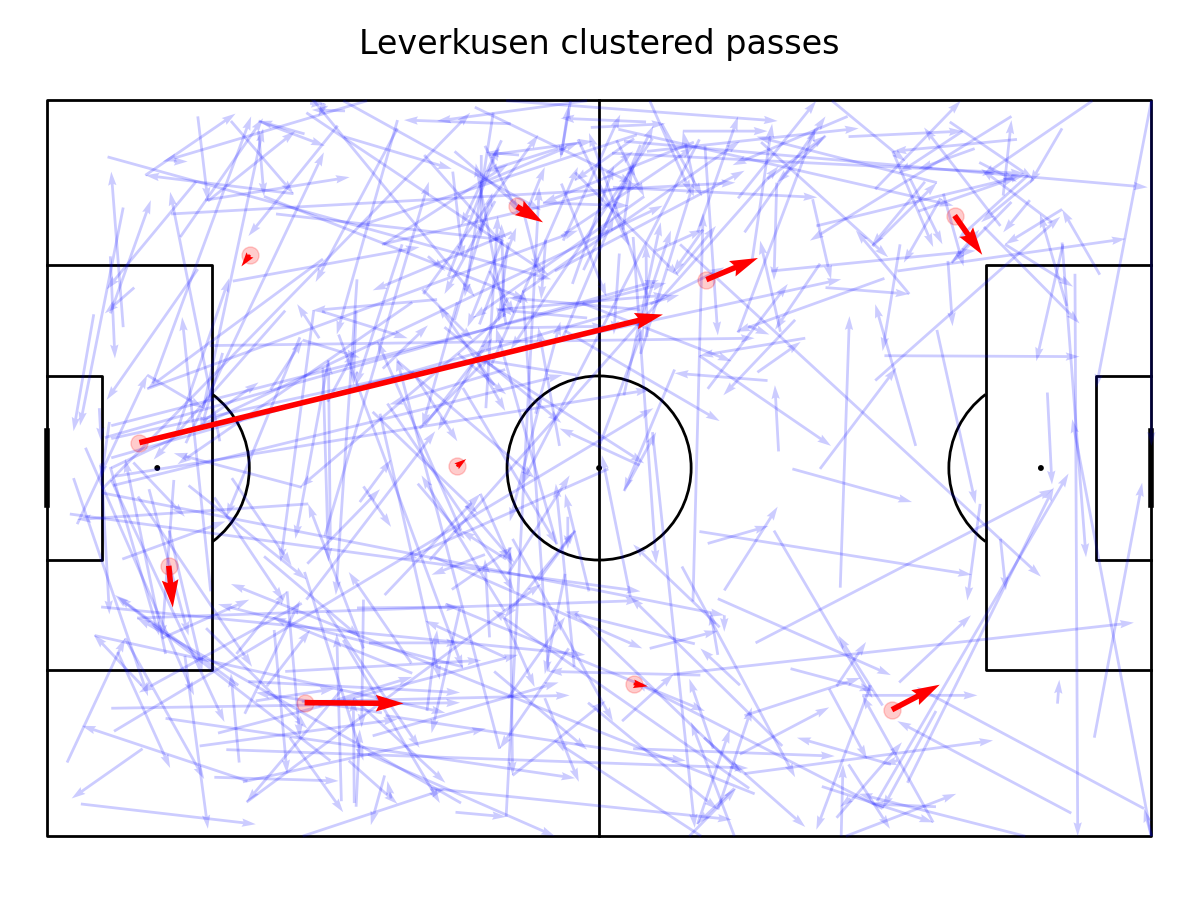

In [67]:
pitch = Pitch('statsbomb', line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

pitch.arrows(lev_pass.x,lev_pass.y,lev_pass.end_x,lev_pass.end_y,color='blue',ax=ax['pitch'],alpha=0.2,width=2)
# pitch.scatter(lev_pass.x,lev_pass.y,alpha=0.2,s=250,color='blue',ax=ax['pitch'])
pitch.arrows(cluster_means.x,cluster_means.y,cluster_means.end_x,cluster_means.end_y,color='red',ax=ax['pitch'],alpha=1,width=4)
pitch.scatter(cluster_means.x,cluster_means.y,alpha=0.2,s=150,color='red',ax=ax['pitch'])
fig.suptitle("Leverkusen clustered passes", fontsize = 24)
plt.show()

In [68]:
lev_pass

,x,y,end_x,end_y,angle,cluster
9,36.6,15.7,50.1,7.0,-0.572460,7
34,56.7,59.6,49.2,70.5,2.173473,2
37,49.2,70.5,38.0,28.0,-1.828467,5
40,39.7,29.5,44.6,37.1,0.998130,5
43,47.7,33.5,49.0,12.6,-1.508675,7
...,...,...,...,...,...,...
4070,10.9,31.4,57.7,14.2,-0.352198,6
4079,62.7,4.5,119.6,9.5,0.087648,3
4099,7.0,40.0,66.9,11.5,-0.444095,6
4121,32.2,0.1,53.7,12.0,0.505517,7


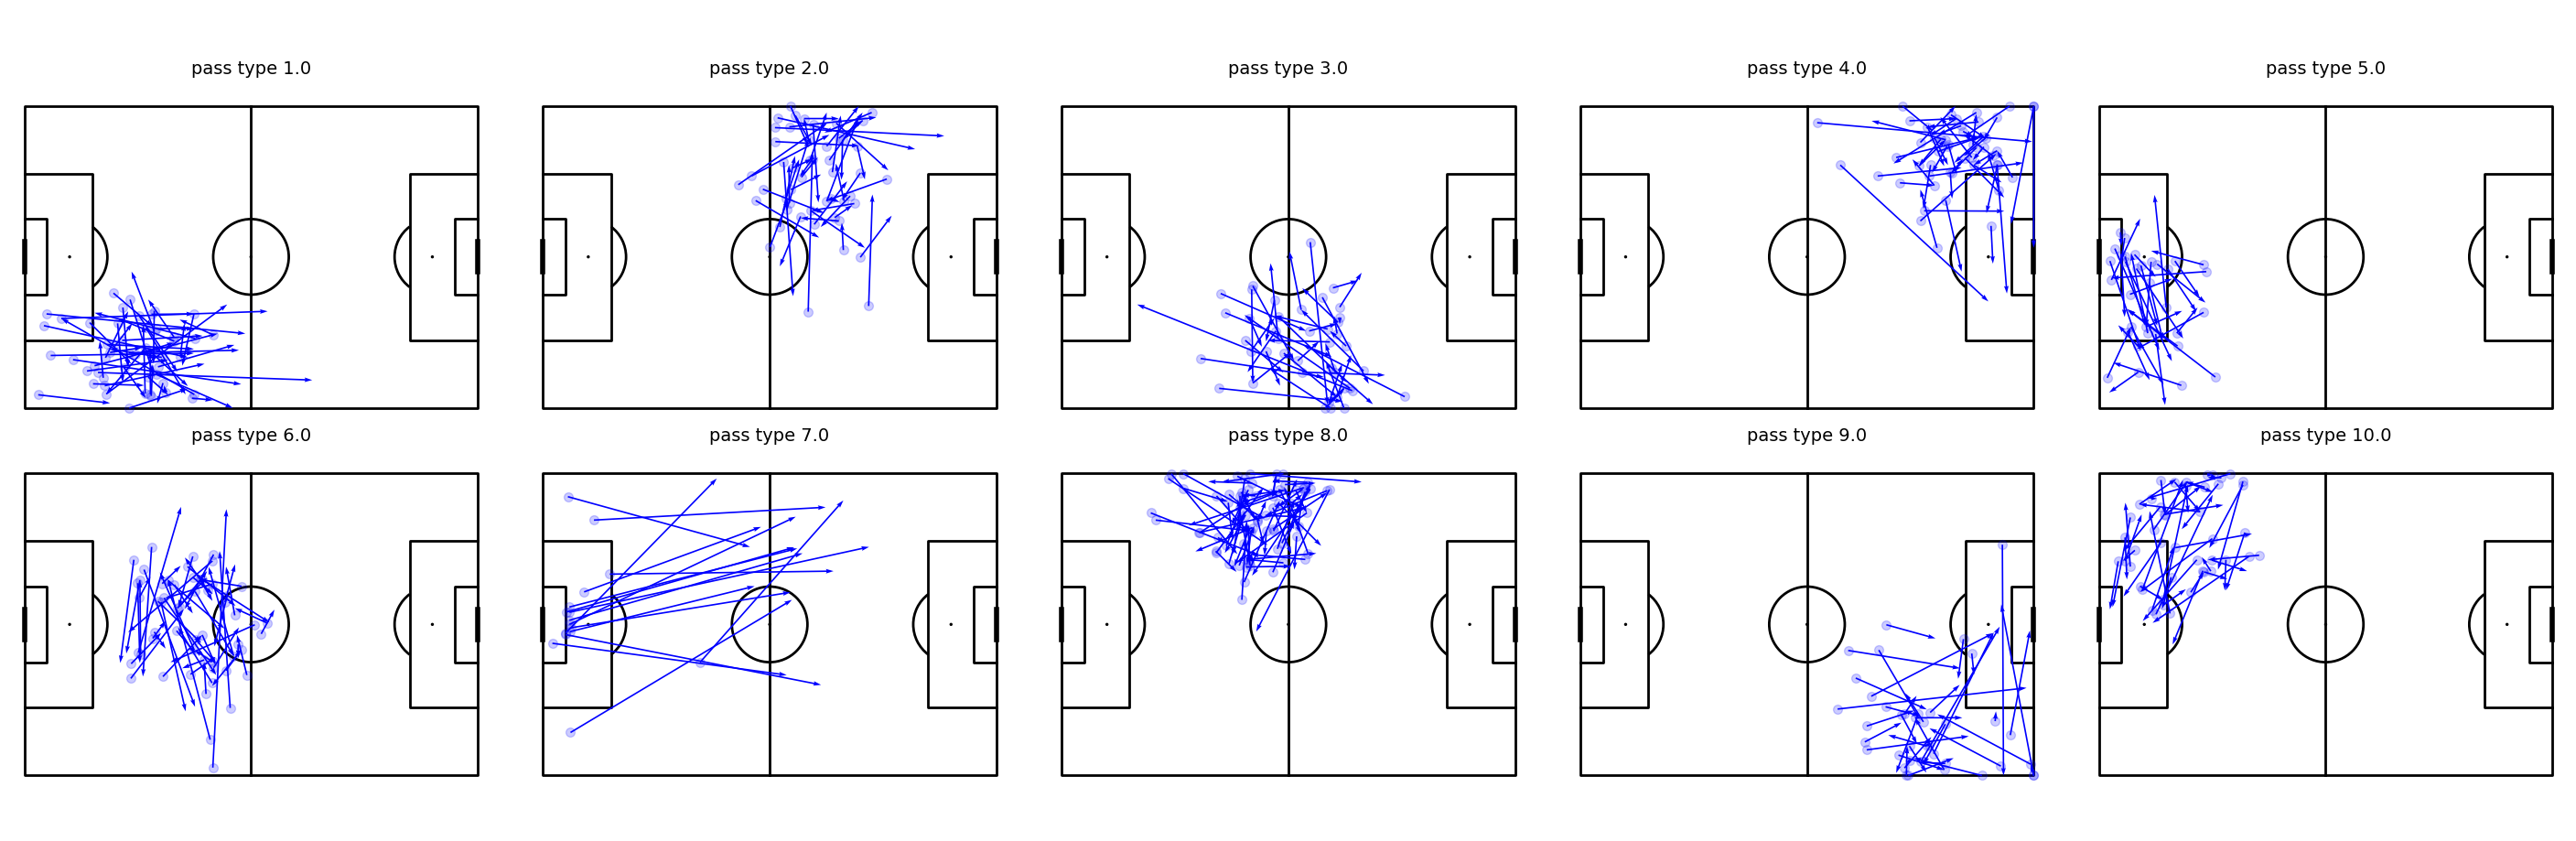

In [75]:
# draw 2x2 pitches
clusters = np.linspace(1,10,10)
pitch = Pitch('statsbomb', line_color='black')
fig, axs = pitch.grid(ncols = 5, nrows = 2, grid_height=0.85, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0.04, endnote_space=0.01)


# for each cluster
for cluster, ax in zip(clusters,axs['pitch'].flat[:len(clusters)]):
    
    ax.text(60,-10,f'pass type {cluster}',ha='center',va='center',fontsize=14)
    
    pass_cluster = lev_pass.loc[lev_pass['cluster']==cluster-1]
    # scatter and arrow
    pitch.arrows(pass_cluster.x,pass_cluster.y,pass_cluster.end_x,pass_cluster.end_y,color='blue',ax=ax, width=1.2)
    pitch.scatter(pass_cluster.x,pass_cluster.y,alpha=0.2,s=50,color='blue',ax=ax)


# # We have more than enough pitches - remove them
# for ax in axs['pitch'][-1, 4 - len(names):]:
#     ax.remove()

# Another way to set title using mplsoccer
# axs['title'].text(0.5, 0.5, 'Real Madrid\'s Midfield Trio', ha='center', va='center', fontsize=30)
plt.show()